In [1]:
import stats_can
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import tensorflow as tf
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
df=stats_can.sc.table_to_df('18-10-0004-01')

In [3]:
df=df[(df['UOM']=='2002=100')&(df['GEO']=='Canada')&(df['Products and product groups']=='All-items')]

In [4]:
df=df.iloc[:,[0,1,3,4,10]]

In [5]:
value=df['VALUE'].values.astype('float64')

In [6]:
X=[]
Y=[]
n_for_predict=3
for i in range(n_for_predict, len(value)):
    X.append(value[i-n_for_predict:i])
    Y.append(value[i:i+1])
X=np.array(X)
Y=np.array(Y)

In [7]:
train_size=int(len(X)*0.7)
test_size = len(X) - train_size

X_train=X[0:train_size]
X_test=X[train_size:len(X)]
Y_train=Y[0:train_size]
Y_test=Y[train_size:len(X)]

In [8]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [9]:
early_stopping=EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min')
model_checkpoint=ModelCheckpoint('model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [10]:
model=Sequential()
model.add(LSTM(16, input_shape=(1, n_for_predict), return_sequences=True, activation='relu'))
model.add(LSTM(8, return_sequences=True, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(0.001))

In [11]:
history=model.fit(X_train, Y_train, epochs=50, validation_data=(X_test, Y_test), callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
29/29 [==============================] - 4s 22ms/step - loss: 742.3463 - val_loss: 12384.4971
Epoch 2/50
29/29 [==============================] - 0s 5ms/step - loss: 711.2886 - val_loss: 10680.1670
Epoch 3/50
29/29 [==============================] - 0s 6ms/step - loss: 545.5927 - val_loss: 5267.9419
Epoch 4/50
29/29 [==============================] - 0s 6ms/step - loss: 85.3301 - val_loss: 271.4156
Epoch 5/50
29/29 [==============================] - 0s 7ms/step - loss: 3.5382 - val_loss: 0.5942
Epoch 6/50
29/29 [==============================] - 0s 6ms/step - loss: 0.8359 - val_loss: 1.5454
Epoch 7/50
29/29 [==============================] - 0s 9ms/step - loss: 0.3980 - val_loss: 0.4260
Epoch 8/50
29/29 [==============================] - 0s 10ms/step - loss: 0.2029 - val_loss: 0.3379
Epoch 9/50
29/29 [==============================] - 0s 11ms/step - loss: 0.1165 - val_loss: 0.3332
Epoch 10/50
29/29 [==============================] - 0s 13ms/step - loss: 0.0804 - val_loss: 0.

In [12]:
model.evaluate(X_test, Y_test, verbose=0)

0.5739732980728149

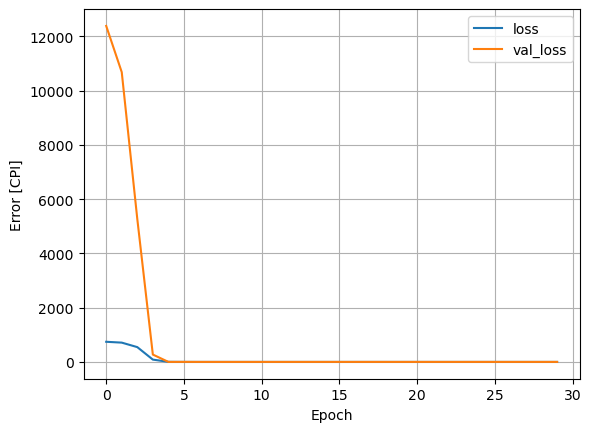

In [13]:
fig = plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error [CPI]')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
train_predict=model.predict(X_train).flatten()
test_predict=model.predict(X_test).flatten()

13/13 [==============================] - 0s 3ms/step


In [15]:
trainPredictPlot = np.empty_like(value)
trainPredictPlot[:] = np.nan
trainPredictPlot[n_for_predict:len(train_predict)+n_for_predict] = train_predict
testPredictPlot = np.empty_like(value)
testPredictPlot[:] = np.nan
testPredictPlot[len(train_predict)+n_for_predict:len(value)] = test_predict

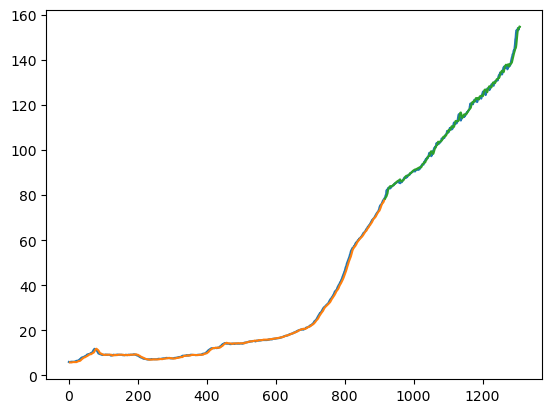

In [16]:
fig = plt.figure()
plt.plot(Y)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [17]:
num_month_prediction=24
predict_period_dates = pd.date_range(start='2023-02-01', periods=num_month_prediction, freq='MS')

In [18]:
prediction_list = value[-n_for_predict:]
for _ in range(num_month_prediction):
    x = prediction_list[-n_for_predict:]
    x = x.reshape((1, 1, n_for_predict))
    pred = model.predict(x)[0][0]
    prediction_list = np.append(prediction_list, pred)
prediction_list=prediction_list[n_for_predict:]

1/1 [==============================] - 0s 31ms/step


In [19]:
pred_result=pd.DataFrame(zip(predict_period_dates, prediction_list), columns=['Dates', 'Prediction'])

In [20]:
start_date=pd.to_datetime('2000-01-01')
end_date=pd.to_datetime('2026-02-01')

(10957.0, 20485.0)

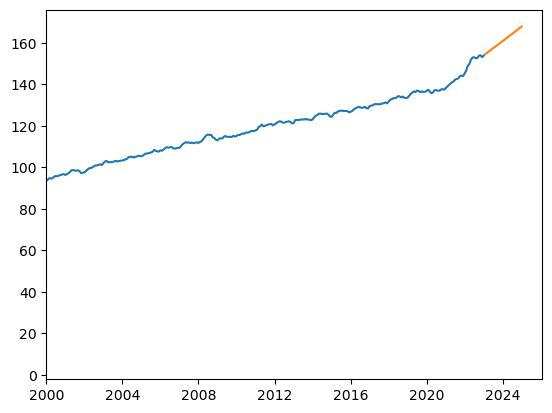

In [21]:
fig = plt.figure()
plt.plot(df['REF_DATE'], df['VALUE'])
plt.plot(pred_result['Dates'], pred_result['Prediction'])
plt.xlim(start_date, end_date)